In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
import os
import sys
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


#%matplotlib qt 


In [2]:
file_name_cube = '/Users/eckhartspalding/Downloads/example_test_s2n_desired_int.fits'

In [3]:
# read in the FITS file
with fits.open(file_name_cube) as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header
    # [0]: S/N values
    # [1]: wavelength bin centers
    # [2]: wavelength bin widths
    # [3]: dark current values




In [4]:
# print the FITS header, one line per keyword
for keyword in hdul[0].header.keys():
    print(f"{keyword}: {hdul[0].header[keyword]}")


SIMPLE: True
BITPIX: -64
NAXIS: 3
NAXIS1: 61
NAXIS2: 1400
NAXIS3: 4
N_INT: 36100


In [17]:
def read_detector_catalog(file_name):
    
    catalog = pd.read_csv(file_name, skipinitialspace=True, delimiter='|', skiprows=1)
    catalog = catalog.rename(columns=lambda x: x.strip()) #strip some of the whitespace

    catalog = catalog.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    catalog['cutoff_blue_um'] = pd.to_numeric(catalog['cutoff_blue_um'])
    catalog['cutoff_red_um'] = pd.to_numeric(catalog['cutoff_red_um'])
    catalog['dark_current_upper (e/pix/sec)'] = pd.to_numeric(catalog['dark_current_upper (e/pix/sec)'])
    catalog['dark_current_lower (e/pix/sec)'] = pd.to_numeric(catalog['dark_current_lower (e/pix/sec)'])
    catalog['dark_current_max (e/pix/sec)'] = catalog[[
        'dark_current_upper (e/pix/sec)',
        'dark_current_lower (e/pix/sec)'
    ]].max(axis=1)
    catalog['string_name'] = catalog['string_name'].str.strip()
    catalog['string_tech'] = catalog['string_tech'].str.strip()

    return catalog

In [32]:
catalog = read_detector_catalog('/Users/eckhartspalding/Documents/git.repos/life_detectors/notebooks/data/detector_catalog.csv')


In [20]:
catalog[['string_name','dark_current_max (e/pix/sec)']]

,string_name,dark_current_max (e/pix/sec)
0,RVS VIRGO/VISTA,1.000000e-01
1,RVS Orion,1.000000e+00
2,MIRI Si:As IBC,1.000000e-01
3,Teledyne H2RG JWST,5.000000e-02
4,Geosnap-18 (DC ~10k),1.000000e+04
5,DRS Technologies WISE,5.000000e+00
6,RVS MWIR HgCdTe,5.000000e-02
7,RVS InSb/III-Vs,NaN
8,RVS LWIR HgCdTe,NaN
9,RVS Aquarius,1.000000e+00


Catalog found, adding horizontal lines...
Added 22 horizontal lines from catalog
Wavelength range: 1.02469507659596 to 19.140469820528534
Sample wavelengths: [ 1.02469508  1.6691203   2.7188211   4.42867307  7.21384177 11.7505881
 19.14046982]


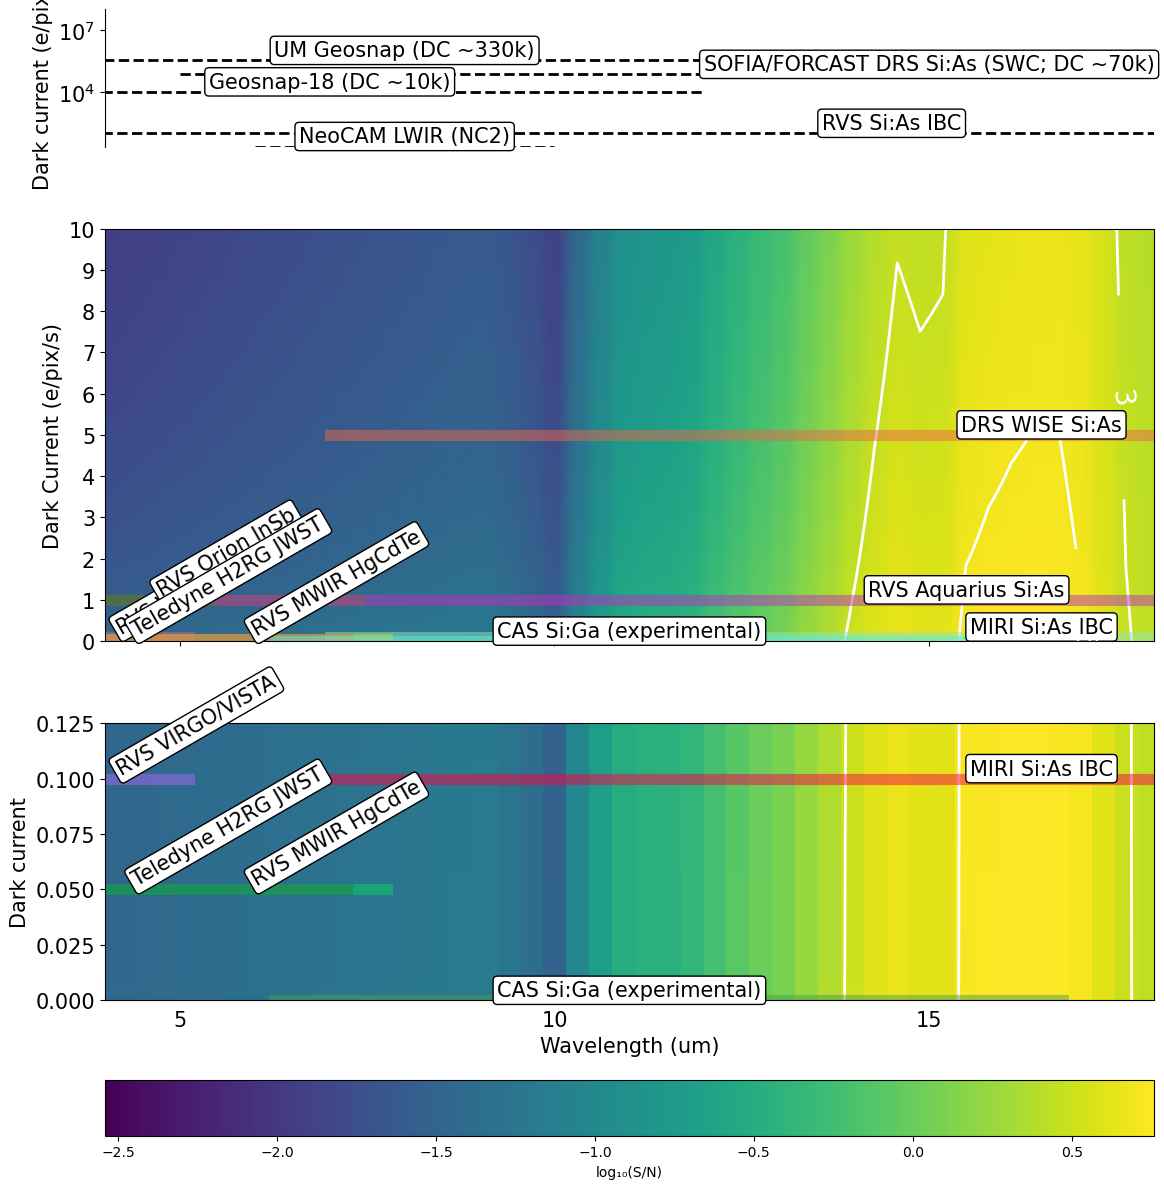

In [ ]:

# ------------------------------------------------------------------------------------------------
# Create heat map of data_cube[0,:,:] with custom tick marks and box widths
fig, (ax_top, ax, ax_bottom) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, height_ratios=[1, 3, 3])
plt.subplots_adjust(hspace=0.01)  # tighten vertical spacing further

# Get the data for the heat map
heatmap_data = data_cube[0,:,:]  # S/N values
wavelength_centers = data_cube[1,:,:]  # Wavelength bin centers
wavelength_widths = data_cube[2,:,:]  # Wavelength bin widths
dark_current_values = data_cube[3,:,:]  # Dark current values

# Calculate the extent for imshow to account for variable bin widths
# We need to create a regular grid that represents the variable-width bins
n_rows, n_cols = heatmap_data.shape

# Create arrays for the edges of each bin
x_edges = np.zeros((n_rows, n_cols + 1))
y_edges = np.zeros((n_rows + 1, n_cols))

# Calculate x-edges (wavelength) for each row
for i in range(n_rows):
    for j in range(n_cols):
        x_edges[i, j] = wavelength_centers[i, j] - wavelength_widths[i, j] / 2
    x_edges[i, -1] = wavelength_centers[i, -1] + wavelength_widths[i, -1] / 2

# Calculate y-edges (dark current) for each column
for j in range(n_cols):
    for i in range(n_rows):
        y_edges[i, j] = dark_current_values[i, j] - 0.5  # Assuming unit spacing for dark current
    y_edges[-1, j] = dark_current_values[-1, j] + 0.5

# Create the extent for imshow
extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]

# Create the heat map
# Option to use logarithmic colorscale
use_log_scale = True  # Set to False for linear scale

if use_log_scale:
    # For log scale, we need to handle zero/negative values
    heatmap_data_log = np.where(heatmap_data > 0, np.log10(heatmap_data), np.nan)
    im_middle = ax.imshow(heatmap_data_log, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    im_bottom = ax_bottom.imshow(heatmap_data_log, extent=extent, aspect='auto', origin='lower', cmap='viridis')
else:
    im_middle = ax.imshow(heatmap_data, extent=extent, aspect='auto', origin='lower', cmap='viridis')
    im_bottom = ax_bottom.imshow(heatmap_data, extent=extent, aspect='auto', origin='lower', cmap='viridis')


# Add contour for S/N = 3
contour_middle = ax.contour(heatmap_data, levels=[3,5], colors=['white'], linewidths=2, extent=extent, origin='lower')
ax.clabel(contour_middle, fmt='%d', colors='white', fontsize=20)
contour_bottom = ax_bottom.contour(heatmap_data, levels=[3,5], colors=['white'], linewidths=2, extent=extent, origin='lower')
ax_bottom.clabel(contour_bottom, fmt='%d', colors='white', fontsize=20)

# Set up the top subplot
ax_top.set_ylim(100, 102)
ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis labels and ticks on ax_top
ax_top.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
for spine in ax_top.spines.values():
    spine.set_visible(False)  # Remove subplot borders

# Set up the bottom subplot
ax_bottom.set_ylim(0, 0.125)
ax_bottom.set_ylabel('DC')
ax_bottom.tick_params(axis='x', which='both', bottom=False, labelbottom=True)  # Hide x-axis labels and ticks on ax_bottom

# the rows where the dark current so high it is off the chart
catalog_top = catalog[catalog['dark_current_max (e/pix/sec)'] > 10].reset_index(drop=True)
catalog_top = catalog_top.sort_values(by='dark_current_max (e/pix/sec)', ascending=False)
# plot horizontal lines, like in the code above, but make the lines dashed and remove all axes and tick marks

# Set y-limits to the min/max of catalog_top dark_current_max values
if len(catalog_top) > 0:
    y_min_top = float(catalog_top['dark_current_max (e/pix/sec)'].min())
    y_max_top = float(catalog_top['dark_current_max (e/pix/sec)'].max())
    ax_top.set_ylim(y_min_top, y_max_top)
    ax_top.set_yscale('log')

# Draw dashed horizontal lines on the top subplot without axes
if len(catalog_top) > 0:
    for i, row in catalog_top.iloc[::-1].iterrows():
        y_val = row['dark_current_max (e/pix/sec)']
        x_start = row['cutoff_blue_um']
        x_end = row['cutoff_red_um']
        ax_top.hlines(y=y_val, xmin=x_start, xmax=x_end, color='k', linestyle='--', linewidth=2, alpha=1.)

        # Add annotation similar to lower plots
        string_name = row['string_name']
        x_mid = (x_start + x_end) / 2
        x_mid_clipped = np.clip(x_mid, 4.0, 18.0)

        rotation_angle_top = 30 if x_mid_clipped < 7 else 0
        x_offset_top = np.random.uniform(0, 2) if rotation_angle_top == 30 else 0

        ax_top.annotate(string_name,
                        xy=(x_mid_clipped, y_val),
                        xytext=(x_mid_clipped + x_offset_top, y_val + 0.05),
                        ha='center', va='bottom',
                        fontsize=15, color='k', alpha=1.,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1.),
                        clip_on=False,
                        rotation=rotation_angle_top)



# Show y-axis on the top subplot; keep x-axis hidden
ax_top.set_axis_on()
for spine in ax_top.spines.values():
    spine.set_visible(False)
ax_top.spines['left'].set_visible(True)
ax_top.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_top.set_ylabel('DC')
    
# Add horizontal lines from catalog data
# Check if catalog exists, if not we'll need to load it
try:
    catalog
    print("Catalog found, adding horizontal lines...")
    
    # Plot horizontal lines for each catalog entry
    for i, row in catalog.iterrows():
        y_val = row['dark_current_max (e/pix/sec)']
        x_start = row['cutoff_blue_um']
        x_end = row['cutoff_red_um']
        string_name = row['string_name']
        
        # Plot lines for y-values in range normally, and out-of-range above the plot, dashed.
        if y_edges.min() <= y_val <= y_edges.max():
            # Middle subplot
            ax.axhline(y=y_val, xmin=(x_start - x_edges.min()) / (x_edges.max() - x_edges.min()), 
                      xmax=(x_end - x_edges.min()) / (x_edges.max() - x_edges.min()), 
                      color=np.random.rand(3,), linewidth=8, alpha=0.5)
            
            # Bottom subplot
            ax_bottom.axhline(y=y_val, xmin=(x_start - x_edges.min()) / (x_edges.max() - x_edges.min()), 
                      xmax=(x_end - x_edges.min()) / (x_edges.max() - x_edges.min()), 
                      color=np.random.rand(3,), linewidth=8, alpha=0.5)
            
            # Add annotation with string_name - both subplots
            x_mid = (x_start + x_end) / 2
            # If x_mid < 5, set x_plot to 5
            x_plot = x_mid if x_mid >= 5 else 5
            
            rotation_angle = 30 if x_plot < 7 else 0
            x_offset = np.random.uniform(0, 3) if rotation_angle == 30 else 0
            
            # Middle subplot annotation
            ax.annotate(string_name, 
                       xy=(x_plot, y_val), 
                       xytext=(x_plot + x_offset, y_val),
                       ha='center', va='bottom',
                       fontsize=15, color='k', alpha=1.,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1.),
                       rotation=rotation_angle)
            
            # Bottom subplot annotation
            ax_bottom.annotate(string_name, 
                       xy=(x_plot, y_val), 
                       xytext=(x_plot + x_offset, y_val),
                       ha='center', va='bottom',
                       fontsize=15, color='k', alpha=1.,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=1.),
                       rotation=rotation_angle)
            
            # Store the annotation object if you want to manipulate it later
            # You can access it via ann if needed
    
    print(f"Added {len(catalog)} horizontal lines from catalog")
    
except NameError:
    print("Catalog not found. Please load the catalog data first.")
    print("Expected columns: 'cutoff_blue_um', 'cutoff_red_um', 'dark_current_upper (e/pix/sec)'")

# Set custom tick marks
# First, let's see what wavelength values we have
print("Wavelength range:", wavelength_centers[0, :].min(), "to", wavelength_centers[0, :].max())
print("Sample wavelengths:", wavelength_centers[0, ::10])  # Every 10th value

# For x-axis: show ticks at multiples of 5 microns (create them if they don't exist in data)
x_min, x_max = wavelength_centers[0, :].min(), wavelength_centers[0, :].max()
x_ticks = np.arange(5, x_max + 1, 5)  # Create ticks at 5, 10, 15, etc.
x_labels = [f'{w:.0f}' for w in x_ticks]
ax_bottom.set_xticks(x_ticks)
ax_bottom.set_xticklabels(x_labels)

# For y-axis: only show ticks at multiples of 10 electrons
y_ticks = []
y_labels = []
for dc in dark_current_values[:, 0]:
    if dc % 1 == 0:  # Check if dark current is a multiple of 10
        y_ticks.append(dc)
        y_labels.append(f'{dc:.0f}')
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)

ax.set_xlim(4, 18)
ax.set_ylim(0, 10)

# Labels and title
ax_bottom.set_xlabel('Wavelength (um)')
ax_bottom.xaxis.label.set_size(15)
ax_bottom.yaxis.label.set_size(15)

ax.set_ylabel('Dark Current (e/pix/s)')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

ax_top.xaxis.label.set_size(15)
ax_top.yaxis.label.set_size(15)

for a in [ax_top, ax, ax_bottom]:
    a.tick_params(axis='both', which='both', labelsize=15)
#ax.set_title('S/N Heat Map')



# Add colorbar along the bottom

divider = make_axes_locatable(ax_bottom)
cax = divider.append_axes("bottom", size="20%", pad=0.8)
cbar = plt.colorbar(im_bottom, cax=cax, orientation='horizontal', fontsize=15)
if use_log_scale:
    cbar.set_label('log₁₀(S/N)')
else:
    cbar.set_label('S/N')

plt.tight_layout()
#plt.show()
plt.savefig('/Users/eckhartspalding/Downloads/junk.png')


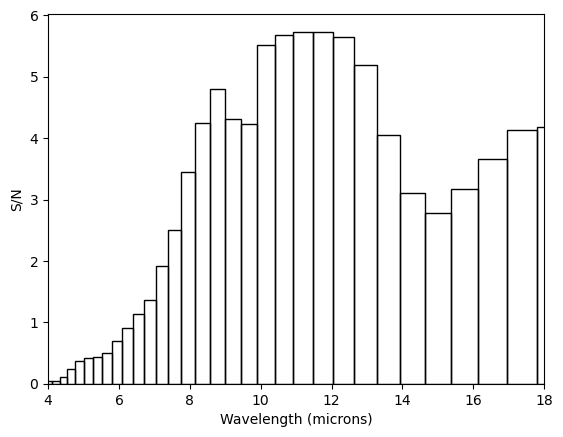

In [5]:
plt.bar(data_cube[1,0,:], data_cube[0,0,:], width=data_cube[2,0,:], 
        fill=False, edgecolor='black', align='center')
plt.xlim([4.0, 18.])
plt.ylabel('S/N')
#plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.savefig('junk1.png')

In [10]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   61                                                  
NAXIS2  =                 1400                                                  
NAXIS3  =                    4                                                  
HIERARCH telescope.collecting_area = '25.0    '                                 
HIERARCH telescope.plate_scale = '0.1     '                                     
HIERARCH telescope.throughput = '0.8     '                                      
HIERARCH telescope.eta_t = '0.05    '                                           
HIERARCH telescope.single_mirror_diameter = '2.0     '                          
HIERARCH target.distance = '10.0    '                                           
HIERARCH target.pl_temp = '2

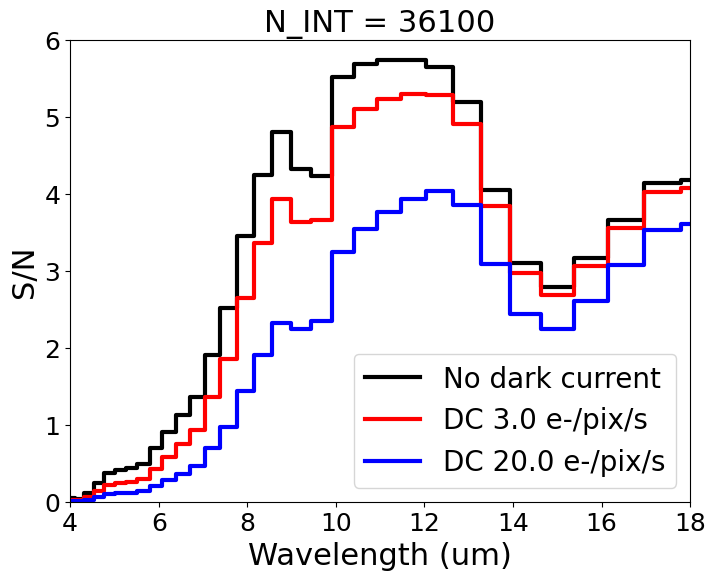

In [44]:
plt.rcParams.update({'font.size': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18, 'axes.labelsize': 22, 'axes.titlesize': 22})

n_int_this = header['N_INT']

n_dc_1 = 60
n_dc_2 = 400

dc_1 = np.median(data_cube[3,n_dc_1,:])
dc_2 = np.median(data_cube[3,n_dc_2,:])


plt.figure(figsize=(8, 6))
plt.title('N_INT = '+str(n_int_this))
plt.step(data_cube[1,0,:], data_cube[0,0,:], where='mid', color='black', linewidth=3, label='No dark current')
plt.step(data_cube[1,n_dc_1,:], data_cube[0,n_dc_1,:], where='mid', color='red', linewidth=3, label='DC '+str(dc_1) + ' e-/pix/s')
plt.step(data_cube[1,n_dc_2,:], data_cube[0,n_dc_2,:], where='mid', color='blue', linewidth=3, label='DC '+str(dc_2) + ' e-/pix/s')
plt.xlim([4.0, 18.])
plt.ylim([0., 6.])
plt.ylabel('S/N')
#plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.legend()
plt.savefig('/Users/eckhartspalding/Downloads/junk2.png')
plt.show()